In [0]:
import torch
import inspect
from torch.utils.data import DataLoader, Dataset

model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
# Use the testing mode for evaluation (the whole ready-to-go model), since we 
# are not contributing to the model itself
# This notebook is optionally accelerated with a GPU runtime.
# If you would like to use this acceleration, please select the menu option 
# "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and
# click "SAVE"
def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
      return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        # p, r, f1, a are all arrays, with each component being a result of a batch
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


In [0]:
# Mount Google Drive to access pictures
from google.colab import drive
drive.mount('/content/gdrive')
# Check if Google Drive is mounted
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  sample_data/


In [0]:
# Fetch 10 different customized images from mounted Google Drive, 
import os
root_path = '/content/gdrive/My Drive/Colab Notebooks/'
filenames = [f for f in os.listdir(root_path + 'HW5_files/') if '.jpg' in f]
print(filenames)
# input parameters for fgsm_attack
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = model
# use GPU
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()

['cat_1.jpg', 'guitar_2.jpg', 'guitar_1.jpg', 'cat_2.jpg', 'dog_2.jpg', 'dog_1.jpg', 'train_1.jpg', 'car_2.jpg', 'car_1.jpg', 'train_2.jpg']


In [0]:
# my dataset

cls_dict = {0: "tabby, tabby cat",
            1: "dingo, warrigal, warragal, Canis dingo",
            2: "sports car, sport car",
            3: "steam locomotive",
            4: "acoustic guitar",
            5: "other"
            }

class MyDataset(Dataset):
    def __init__(self, filelist, root_dir, transform):
        self.filelist = filelist
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, idx):
        img_name = self.filelist[idx]
        fullname = os.path.join(self.root_dir, img_name)
        image = Image.open(fullname)
        if "cat" in img_name:
          cls = 0
        elif "dog" in img_name:
          cls = 1
        elif "car" in img_name:
          cls = 2
        elif "train" in img_name:
          cls = 3
        elif "guitar" in img_name:
          cls = 4
        else:
            raise Exception("Input Image Not Labelled Correctly")
        if self.transform:
            image = self.transform(image)
        return [image, cls]

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
accuracies = []
examples = []

# our 10 image 5 class test loader
transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
  ])
dataset = MyDataset(filenames, root_path+'HW5_files/', transform)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 0 / 10 = 0.0
Epsilon: 0.05	Test Accuracy = 0 / 10 = 0.0
Epsilon: 0.1	Test Accuracy = 0 / 10 = 0.0
Epsilon: 0.15	Test Accuracy = 0 / 10 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 10 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 10 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 10 = 0.0


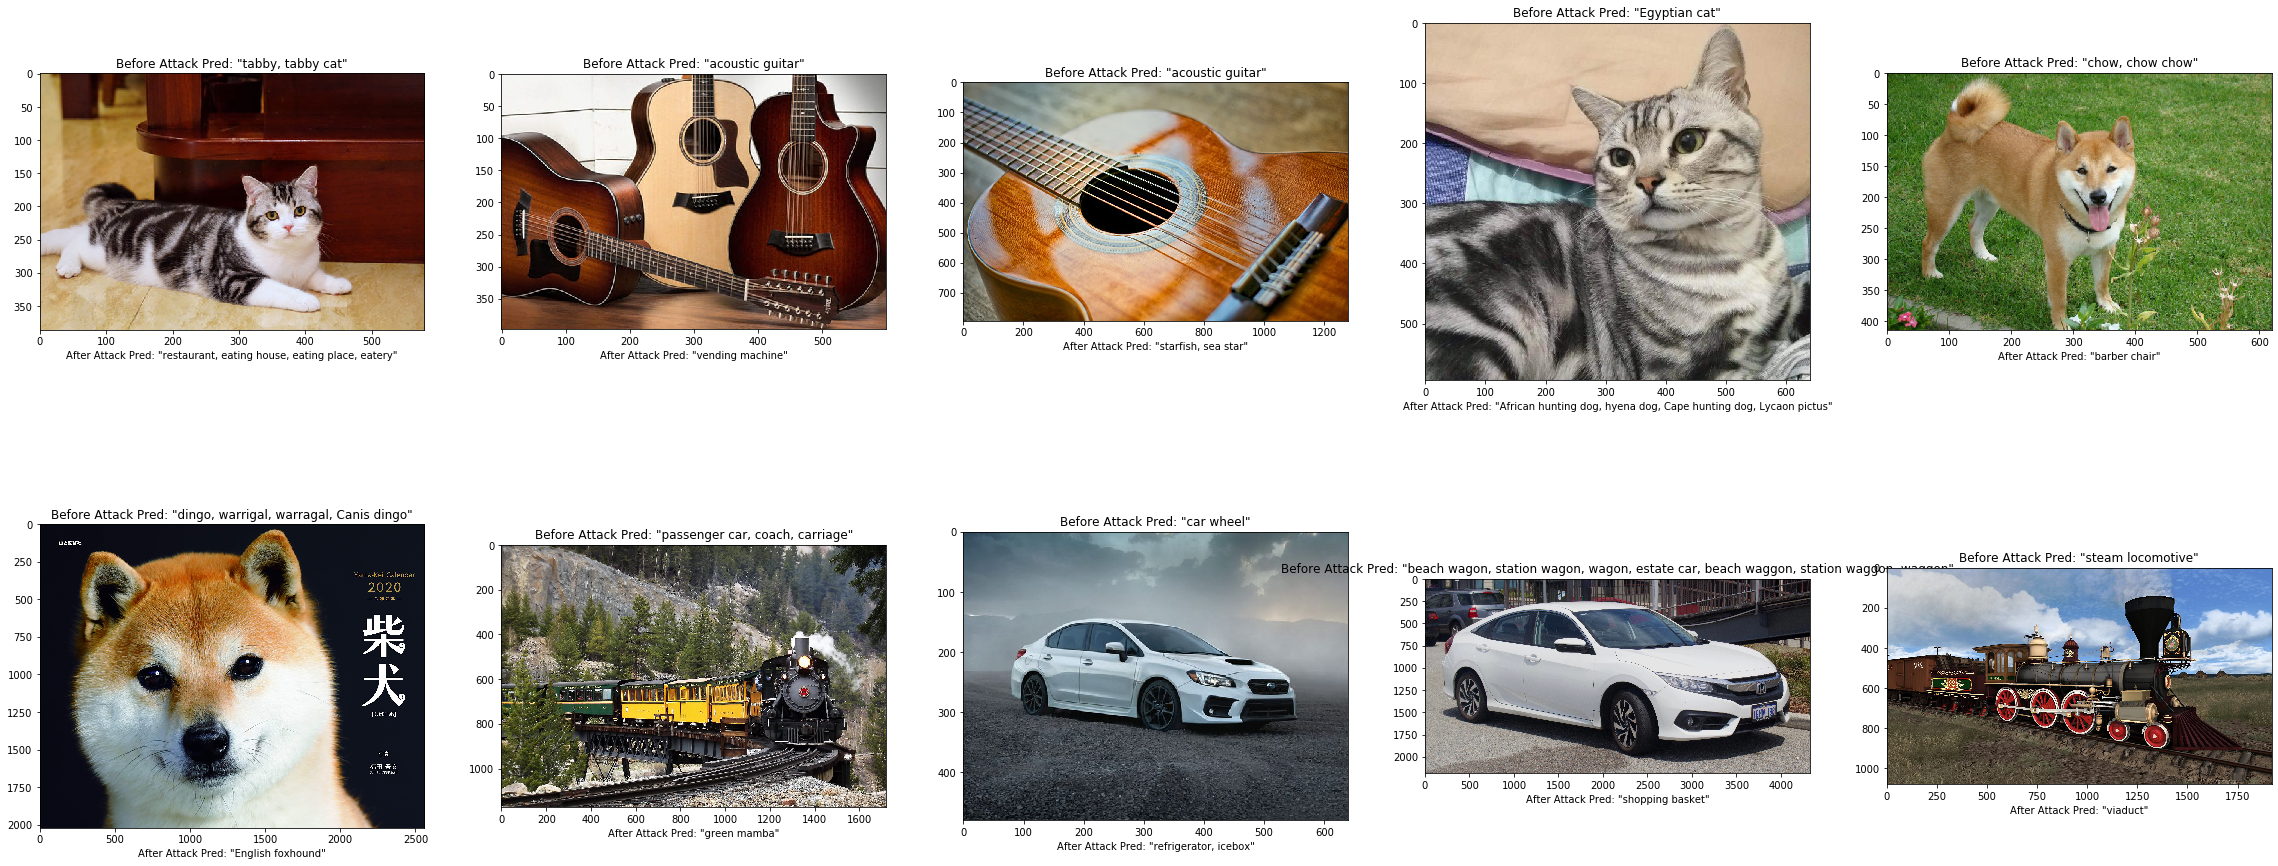

In [0]:
# sample classification
%matplotlib inline
from PIL import Image
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np


file_dirs = [root_path + 'HW5_files/' + x for x in filenames]
input_images = [Image.open(x) for x in file_dirs]

with open(root_path + 'imagenet_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

# the labels of the 10 images that I personally labeled
my_labels = ["tabby, tabby cat",
             "dingo, warrigal, warragal, Canis dingo",
             "sports car, sport car",
             "steam locomotive",
             "acoustic guitar",
             "other"]

model.eval()
test_true, test_pred = [], []
plt.figure(figsize=(40,16))
for i in range(len(input_images)):
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
  ])
  # All pre-trained models expect input images normalized in the same way, 
  # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where 
  # H and W are expected to be at least 224. The images have to be loaded in to 
  # a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] 
  # and std = [0.229, 0.224, 0.225].
  # mean and std is obtained by computer vision scientists with huge datasets.
  input_tensor = preprocess(input_images[i])
  epsilon = 0.9
  attacked_tensor = input_tensor + epsilon * np.sign(random.random())
  input_batch = input_tensor.unsqueeze(0)
  attacked_batch = attacked_tensor.unsqueeze(0)
  # create a mini-batch as expected by the model
  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      attacked_batch = attacked_batch.to('cuda')
      model.to('cuda')
  
  # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
  with torch.no_grad():
      output = model(input_batch)
      attack_output = model(attacked_batch)
  _, index = torch.max(output, 1)
  _, attack_idx = torch.max(attack_output, 1)
  # The output has unnormalized scores. To get probabilities, run a 
  # softmax on it (to normalize the scores to probability).
  percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
  attackpercentage = torch.nn.functional.softmax(attack_output, dim=1)[0] * 100
  plt.subplot(2,5,i+1)
  pred_label_i = labels[index[0]]
  attk_label_i = labels[attack_idx[0]]
  img = mpimg.imread(file_dirs[i])
  test_true.append(true_label_i)
  test_pred.append(pred_label_i if pred_label_i in test_true else "other")
  plt.title(f"Before Attack Pred: \"{pred_label_i}\"")
  plt.xlabel(f"After Attack Pred: \"{attk_label_i}\"")
  plt.imshow(img)
  